In [297]:
import torch
import torchvision
import numpy as np
import pandas as pd
import time
import mat73 # use HDF reader for matlab v7.3 files
import h5py
import cv2
import matplotlib.pyplot as plt
import torch.fft as fft # from torch.fft import fft 사용 시 오류 발생

from cmath import pi

import scipy # for import .mat file
from scipy import io # for import .mat file
from scipy import linalg
from tqdm import tqdm # for visualizing the progress on for-loop

!nvcc --version
torch.__version__

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    
# device = torch.device("cpu")
# torch.set_num_threads(12)

print(f'Device : {device}')
print(f'number of threads : {torch.get_num_threads()}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Mon_Sep_13_19:13:29_PDT_2021
Cuda compilation tools, release 11.5, V11.5.50
Build cuda_11.5.r11.5/compiler.30411180_0
Device : cuda:0
number of threads : 1


In [298]:
# Load input parameters
n_mode = 3
nx = int((n_mode+1)*(n_mode+2)/2 - 3) # number of state

## input_data_3layer_mainly_frozen_v3_128.mat
input_data_3layer_mainly_frozen_v3_128 = scipy.io.loadmat('./input_data/input_data_3layer_mainly_frozen_v3_128.mat')
ad_acc = torch.tensor(input_data_3layer_mainly_frozen_v3_128['ad_acc'])
ad_acc = np.delete(ad_acc, 0, axis=1) # piston element is removed
phase = torch.tensor(input_data_3layer_mainly_frozen_v3_128['phase'])

## model_A_15_v2_128.mat
model_A = mat73.loadmat('./input_data/model_A_B/model_A_%d_v2_128.mat' %(nx+2))
A = torch.tensor(model_A['A'].T[2:,2:], dtype=torch.float64) # A1 = A1'
A1 = torch.tensor(model_A['A1'].T[2:,2:], dtype=torch.float64) # A2 = A2'
A2 = torch.tensor(model_A['A2'].T[2:,2:], dtype=torch.float64) # A2 = A2'

## model_B_15_88.mat
model_B = mat73.loadmat('./input_data/model_A_B/model_B_%d_88.mat' %(nx+3))
B = torch.tensor(model_B['B'][3:,:], dtype=torch.float64)
# B = np.delete(B, 0, axis=0) # piston element is removed

# ## model_B_pupil_active144.mat
# model_B_pupil = mat73.loadmat('./input_data/model_B_pupil_active144.mat')
# B_pupil = torch.tensor(model_B_pupil['B_pupil'])

## model_approx_pd10_128_14.mat
model_approx = mat73.loadmat('./input_data/model_approx/model_approx_pd10_128_%d.mat' %(nx+2))
A_s = torch.tensor(model_approx['A_s'][:,2:])
b_s = torch.tensor(model_approx['b_s'])

## Zs.mat (91 x 128 x 128)
Zs = mat73.loadmat('./input_data/Zs.mat')
Zs = torch.tensor(Zs['Zs'])



In [299]:
# with h5py.File('./input_data/model_A_15_v2_128.mat', 'r') as file:
#     print(file.keys())
#     A = np.array(file['A'], dtype=np.float64)
#     A1 = np.array(file['A1'], dtype=np.float64)

# print(B.dtype)

In [300]:
# Parameter setting
TSim = 1000
reg_para = 1e-40
norm_para = 1e+15
beta_1 = 0.9
beta_2 = 0.999
epsilon_adam = 1e-8

# nx = A.shape[0]; # number of state
nu = B.shape[1]; # number of input

x0 = torch.zeros(nx, device=device, dtype=torch.float64) # dtype=torch.complex128

# Aberration magnitude
mag_conv_5 = 1;
mag_conv_7p5 = 1.401982897784687;
mag_conv_10 = 1.781797436291855;
mag_conv_12p5 = 2.145935547352314;
mag_conv_15 = 2.498049532979032;
mag_conv_20 = 3.174802103932926;
mag_conv_22p5 = 3.502222723017048;
mag_conv_25 = 3.823622456658651;

# Phase diversity setting
zd_list = [-10, 0, 10]

num_train = 1000
num_valid = 500
num_test = 500



In [301]:
# Setting Aberration magnitude
case_num = 5

D_r0 = f'mag_conv_{case_num}'

phase = phase * eval(D_r0);
ad_acc = ad_acc * eval(D_r0);


In [302]:
# Make pixel array
p_len = 128 # number of pixels in the array
dom_len = 64

range_min = torch.tensor([int((p_len - dom_len)/2)])
range_max = torch.tensor([int((p_len + dom_len)/2)])
diff = range_max - range_min

mag = 1
res = p_len*mag # resolution of FFT 
cen = p_len/2 + 1
dx = 6.5e-6 # 0.1e-6;   % pixel spacing (m)
df = 1/(p_len*dx) # spacing in the spatial frequency domain (cycles/m)

# Make input object
xaxis = torch.arange(-p_len/2, p_len/2)*dx
yaxis = -xaxis

xaxis_res = torch.arange(-res/2, res/2)*dx/mag;
yaxis_res = -xaxis_res;

# [XX,YY] = meshgrid(xaxis,yaxis);

fxaxis = torch.arange(-p_len/2, p_len/2)*df
fyaxis = -fxaxis
FX,FY = torch.meshgrid(fxaxis,fyaxis) # 2-D arrays hold fx location and fy location of all points
freq_rad = torch.sqrt(FX ** 2 + FY ** 2)
maxfreq = (p_len/2-1)*df;
pupil_radius = 1.0*maxfreq;

pupil = (freq_rad <= pupil_radius).int().to(device) # pin-hole // double(freq_rad <= pupil_radius)


wavelength = 532.0e-9; # [m]
rad = wavelength/(2*pi) # [rad]
wavenumber = (2*pi)/wavelength # wavenumber (1/m)
NA = 1.3 #  Numerical aperture of the objective
power = 0.1 # Watts
Z0 = 376.73 # Ohms; impedance of free space

# range_min = torch.where(torch.abs(xaxis_res-(-1.0e-4)) < 3e-6)[0] - 1 # 47
# range_max = torch.where(torch.abs(xaxis_res-(+1.0e-4)) < 3e-6)[0] + 1 # 80
# diff = range_max - range_min


In [303]:
# LQR setting
N = 5 # prediction horizon for LQR

## J = U'*H*U + r'*U + c
Q = (1.5e+2)*torch.eye(nx,nx, dtype=torch.float64) # weighting matrix for error state
P = (1e+0)*Q # weighting matrix for terminal error 
R = (1e+0)*torch.eye(nu,nu, dtype=torch.float64) # weighting matrix for cost function

coeff_a = 0.047275
coeff_b = 2.709264
coeff_c = 0 # Unit change parameters (Voltage to Deflection)
unit_change = wavelength/(2*pi)*1e+9 # [rad] to [nm]

In [304]:
# Design matrix generation for Linear MPC
## For VAR(1) model - MPC_DesignMatrices_v3

# [H_v1, M_v1, Q_tilda_v1, R_tilda_v1, B_conv_v1, B_conv_pre_v1, E_v1] = MPC_DesignMatrices_v3(A,B,nx,nu,N,Q,P,R);
# closed_form_matrix_v1 = -0.5*(pinv(H_v1'*H_v1))*(H_v1');

def MPC_DesignMatrices_v3(A,B,nx,nu,N,Q,P,R):
    M = torch.zeros((nx*N,nx))
    for i in range(N):
        M[nx*i:nx*(i+1),:] = A ** (i+1)
        
    Q_tilda = torch.zeros((nx*N,nx*N), dtype=torch.float64)
    for i in range(N-1):
        Q_tilda[(i*nx):(i+1)*nx,(i*nx):(i+1)*nx] = Q
    Q_tilda[(N-1)*nx:N*nx,(N-1)*nx:] = P;
    
    R_tilda = torch.zeros((nu*N,nu*N), dtype=torch.float64);
    for i in range(N):
        R_tilda[(i*nu):(i+1)*nu,(i*nu):(i+1)*nu] = R

    B_cell = torch.tile(B, (1, N))

    B_cell = [B]*N
    B_conv = torch.tensor(scipy.linalg.block_diag(*B_cell))

    B_conv_pre = torch.zeros((nx*N,nu), dtype=torch.float64)
    for i in range(N):
        B_conv_pre[nx*i:nx*(i+1),:] = -torch.matmul((A ** (i+1)),B)

    H = 0.5*( torch.matmul(torch.matmul((B_conv).T, Q_tilda),B_conv) + torch.matmul(torch.matmul((B_conv).T, Q_tilda),B_conv).T ) + R_tilda
    
    if N==1:
        E = torch.eye(nu,nu, dtype=torch.float64)
    else:
        E = torch.zeros((nu*N,nu*N), dtype=torch.float64)
        for i in range(N):
            if i==0:
                E[i*nu:(i+1)*nu,i*nu:(i+1)*nu] = torch.eye(nu,nu);
            else:
                E[i*nu:(i+1)*nu,(i-1)*nu:i*nu] = -torch.eye(nu,nu);
                E[i*nu:(i+1)*nu,i*nu:(i+1)*nu] = torch.eye(nu,nu);
            
    
    return H, M, Q_tilda, R_tilda, B_conv, B_conv_pre, E

In [305]:
# Design matrix generation for Linear MPC
## For VAR(2) model - MPC_DesignMatrices_v4

# [H_v1, M_v1, Q_tilda_v1, R_tilda_v1, B_conv_v1, B_conv_pre_v1, E_v1] = MPC_DesignMatrices_v3(A,B,nx,nu,N,Q,P,R);
# closed_form_matrix_v1 = -0.5*(pinv(H_v1'*H_v1))*(H_v1');

def MPC_DesignMatrices_v4(A1,A2,B,nx,nu,N,Q,P,R):
    M1 = torch.zeros((nx*N,nx), dtype=torch.float64)
    M2 = torch.zeros((nx*N,nx), dtype=torch.float64)
    
    for i in range(N):
        if i==0:
            M1[nx*i:nx*(i+1),:] = A1;
            M2[nx*i:nx*(i+1),:] = A2;
        elif i==1:
            M1[nx*i:nx*(i+1),:] = (A1) ** 2 + A2;
            M2[nx*i:nx*(i+1),:] = torch.matmul(A1,A2);
        else:
            M1[nx*i:nx*(i+1),:] =  torch.matmul(A1,M1[nx*(i-1):nx*i,:]) + torch.matmul(A2, M1[nx*(i-2):nx*(i-1),:])
            M2[nx*i:nx*(i+1),:] =  torch.matmul(M1[nx*(i-1):nx*i,:],A2)
        
    Q_tilda = torch.zeros((nx*N,nx*N), dtype=torch.float64)
    for i in range(N-1):
        Q_tilda[(i*nx):(i+1)*nx,(i*nx):(i+1)*nx] = Q
    Q_tilda[(N-1)*nx:N*nx,(N-1)*nx:] = P;
    
    R_tilda = torch.zeros((nu*N,nu*N), dtype=torch.float64);
    for i in range(N):
        R_tilda[(i*nu):(i+1)*nu,(i*nu):(i+1)*nu] = R

    B_cell = torch.tile(B, (1, N))

    B_cell = [B]*N
    B_conv = torch.tensor(scipy.linalg.block_diag(*B_cell))

    B_conv_pre1 = -torch.matmul(M1, B)
    B_conv_pre2 = -torch.matmul(M2, B)

    H = 0.5*( torch.matmul(torch.matmul((B_conv).T, Q_tilda),B_conv) + torch.matmul(torch.matmul((B_conv).T, Q_tilda),B_conv).T ) + R_tilda
    
    if N==1:
        E = torch.eye(nu,nu, dtype=torch.float64)
    else:
        E = torch.zeros((nu*N,nu*N), dtype=torch.float64)
        for i in range(N):
            if i==0:
                E[i*nu:(i+1)*nu,i*nu:(i+1)*nu] = torch.eye(nu,nu);
            else:
                E[i*nu:(i+1)*nu,(i-1)*nu:i*nu] = -torch.eye(nu,nu);
                E[i*nu:(i+1)*nu,i*nu:(i+1)*nu] = torch.eye(nu,nu);
            
    
    return H, M1, M2, Q_tilda, R_tilda, B_conv, B_conv_pre1, B_conv_pre2, E

In [306]:
[H_v1, M_v1, Q_tilda_v1, R_tilda_v1, B_conv_v1, B_conv_pre_v1, E_v1] = MPC_DesignMatrices_v3(A,B,nx,nu,N,Q,P,R)
[H, M1, M2, Q_tilda, R_tilda, B_conv, B_conv_pre_v1, B_conv_pre_v2, E] = MPC_DesignMatrices_v4(A1,A2,B,nx,nu,N,Q,P,R)

closed_form_matrix_v1 = -0.5*torch.matmul(torch.linalg.pinv(torch.matmul(H_v1.T, H_v1)), H_v1.T)
closed_form_matrix_v2 = -0.5*torch.matmul(torch.linalg.pinv(torch.matmul(H.T, H)), H.T)

In [307]:
# # Load the object image
# # reference to cv2 options - https://076923.github.io/posts/Python-opencv-8/
# # MATLAB vs Python - https://stackoverflow.com/questions/21997094/why-opencv-cv2-resize-gives-different-answer-than-matlab-imresize
# # Antialising

# from torch import fft

# Objimage = cv2.imread('./input_data/usaf_1951.jpg', cv2.IMREAD_GRAYSCALE) + 1 # cv2.IMREAD_COLOR
# Obj = np.double(Objimage) # image dtype converting : int -> double
# Obj = torch.tensor(cv2.resize(Obj, dsize=(p_len,p_len), interpolation=cv2.INTER_CUBIC)) # resize : [800, 618] -> [128, 128]
# # xxx = Obj.resize((p_len, p_len), Image.ANTIALIAS)

# fObj = fft.fftshift(fft.fft2(fft.ifftshift(Obj))) # Object image -> frequency domain (FFT)

In [308]:
# Obj와 fObj는 MATLAB imresize와 결과가 달라 그냥 MATLAB data로 받아오도록 변형
Obj = scipy.io.loadmat('./input_data/Obj.mat')
Obj = torch.tensor(Obj['Obj']) # dtype=torch.float64

fObj = scipy.io.loadmat('./input_data/fObj.mat')
fObj = torch.tensor(fObj['fObj']) # dtype=torch.float64

In [309]:
# to cuda
def to_cuda(data, device):
    data = data.to(device)
    return data

In [310]:
class ADAML_original():
    def __init__(self, params, fImag_torch, pre_data2_torch):
        self.params = params
        
        self.fImag_torch = fImag_torch
        self.pre_data2_torch = pre_data2_torch
        
    def fv_im_cal(self, ad_acc_evaluated):
        phase_eval = torch.sum(self.params['Zs'][3:nx+3,:,:] * ad_acc_evaluated[:,None,None], 0).to(device)
            
        ## Original PSF generation
        # v_im = torch.zeros(self.params['dom_len'],self.params['dom_len'],len(self.params['zd_list']))
        fv_im = torch.zeros(self.params['dom_len'],self.params['dom_len'],len(self.params['zd_list']), dtype=torch.complex128)
        fv_im_conj = torch.zeros(self.params['dom_len'],self.params['dom_len'],len(self.params['zd_list']), dtype=torch.complex128)
        fv_im_grad = torch.zeros(self.params['dom_len'], self.params['dom_len'], len(self.params['zd_list']), self.params['nx'], dtype=torch.complex128)
        I1_defocus = torch.zeros(self.params['p_len'], self.params['p_len'], self.params['nx'], dtype=torch.complex128, device=device)
        
        for k in range(len(zd_list)):
            kW = zd_list[k] * self.params['Zs'][self.params['idx2'],:,:]
                
            P_defocus = pupil * torch.exp(1j*(phase_eval + kW)) # DH-PSF (gaussian is removed)
                    
            ## transfer function
            I_defocus = fft.fftshift(fft.fft2(fft.ifftshift(P_defocus))) * (self.params['dx'] ** 2)
            v_im_total = (torch.abs(I_defocus) ** 2)
                                
            ## Obtain FFT of Image intensity distribution (by inverse FFT)
            fv_im[:,:,k] = fft.fftshift(fft.fft2(fft.ifftshift(v_im_total)))[self.params['range_min']:self.params['range_max'], self.params['range_min']:self.params['range_max']]
            fv_im_conj[:,:,k] = torch.conj(fv_im[:,:,k])
            
            P1_defocus = P_defocus[:,:,None] * self.params['Zs'][3:self.params['nx']+3,:,:].permute(1,2,0).to(device)
            I1_defocus = fft.fftshift(fft.fftn(fft.ifftshift(P1_defocus), dim=(0,1))) * (self.params['dx'] ** 2)
            fv_im_grad[:,:,k,:] = fft.fftshift(fft.fftn(fft.ifftshift( -2*torch.imag(I1_defocus * torch.conj(I_defocus)[:,:,None]) ), dim=(0,1)))[self.params['range_min']:self.params['range_max'], self.params['range_min']:self.params['range_max'],:]
            
            # for j in range(self.params['nx']):
            #     I1_defocus[:,:,j] = fft.fftshift(fft.fft2(fft.ifftshift(P1_defocus[:,:,j]))) * (self.params['dx'] ** 2)
            #     fv_im_grad[:,:,k,j] = fft.fftshift(fft.fft2(fft.ifftshift( -2*torch.imag(I1_defocus[:,:,j] * torch.conj(I_defocus)) )))[self.params['range_min']:self.params['range_max'], self.params['range_min']:self.params['range_max']]

        
        fv_im_torch = fv_im.to(device)
        fv_im_conj_torch = fv_im_conj.to(device)
        fv_im_grad_torch = fv_im_grad.to(device)
        fv_im_grad_conj_torch = torch.conj(fv_im_grad_torch)
        
        return fv_im_torch, fv_im_conj_torch, fv_im_grad_torch, fv_im_grad_conj_torch
        
    def temp_cal(self, fv_im_torch, fv_im_grad_torch):    
        temp1_1 = self.fImag_torch[:,:,0] * fv_im_torch[:,:,2] - self.fImag_torch[:,:,2] * fv_im_torch[:,:,0]
        temp1_2 = self.fImag_torch[:,:,0] * fv_im_torch[:,:,1] - self.fImag_torch[:,:,1] * fv_im_torch[:,:,0]
        temp1_3 = self.fImag_torch[:,:,1] * fv_im_torch[:,:,2] - self.fImag_torch[:,:,2] * fv_im_torch[:,:,1]

        temp1_1_conj = torch.conj(temp1_1)
        temp1_2_conj = torch.conj(temp1_2)
        temp1_3_conj = torch.conj(temp1_3)
        
        temp2 = torch.abs(fv_im_torch[:,:,0]) ** 2 + torch.abs(fv_im_torch[:,:,1]) ** 2 + torch.abs(fv_im_torch[:,:,2]) ** 2 + reg_para*torch.ones(self.params['dom_len'],self.params['dom_len'], device=device) # print(temp2.is_cuda)

        temp3 = torch.abs( self.fImag_torch[:,:,0] * fv_im_torch[:,:,2] - self.fImag_torch[:,:,2] * fv_im_torch[:,:,0] ) ** 2 \
                + torch.abs( self.fImag_torch[:,:,0] * fv_im_torch[:,:,1] - self.fImag_torch[:,:,1] * fv_im_torch[:,:,0] ) ** 2 \
                + torch.abs( self.fImag_torch[:,:,1] * fv_im_torch[:,:,2] - self.fImag_torch[:,:,2] * fv_im_torch[:,:,1] ) ** 2 + self.pre_data2_torch
        
        pre_data1 = torch.zeros(self.params['dom_len'],self.params['dom_len'],6,nx, dtype=torch.complex128)
        
        pre_data1[:,:,0,:] = self.fImag_torch[:,:,0,None] * fv_im_grad_torch[:,:,2,:] - self.fImag_torch[:,:,2,None] * fv_im_grad_torch[:,:,0,:]
        pre_data1[:,:,1,:] = torch.conj( pre_data1[:,:,0,:] )
        pre_data1[:,:,2,:] = self.fImag_torch[:,:,0,None] * fv_im_grad_torch[:,:,1,:] - self.fImag_torch[:,:,1,None] * fv_im_grad_torch[:,:,0,:]
        pre_data1[:,:,3,:] = torch.conj( pre_data1[:,:,2,:] )
        pre_data1[:,:,4,:] = self.fImag_torch[:,:,1,None] * fv_im_grad_torch[:,:,2,:] - self.fImag_torch[:,:,2,None] * fv_im_grad_torch[:,:,1,:]
        pre_data1[:,:,5,:] = torch.conj( pre_data1[:,:,4,:] )
        
        pre_data1_torch = pre_data1.to(device)
        
        # print(self.fImag_torch.shape, fv_im_grad_torch.shape)
        
        return temp1_1, temp1_2, temp1_3, temp1_1_conj, temp1_2_conj, temp1_3_conj, temp2, temp3, pre_data1_torch
        
    def E_metric_cal(self, fv_im_torch, fv_im_conj_torch, fv_im_grad_torch, fv_im_grad_conj_torch, temp1_1, temp1_2, temp1_3, temp1_1_conj, temp1_2_conj, temp1_3_conj, temp2, temp3, pre_data1_torch):
        denom = temp2 ** 2
        
        numer1 = ( ( pre_data1_torch[:,:,0,:] * temp1_1_conj[:,:,None] + temp1_1[:,:,None] * pre_data1_torch[:,:,1,:] ) \
                    + ( pre_data1_torch[:,:,2,:] * temp1_2_conj[:,:,None] + temp1_2[:,:,None] * pre_data1_torch[:,:,3,:] ) \
                    + ( pre_data1_torch[:,:,4,:] * temp1_3_conj[:,:,None] + temp1_3[:,:,None] * pre_data1_torch[:,:,5,:] ) ) * ( temp2[:,:,None] )

        numer2 = ( temp3[:,:,None] ) \
                * ( fv_im_grad_torch[:,:,0,:] * fv_im_conj_torch[:,:,0,None] + fv_im_torch[:,:,0,None] * fv_im_grad_conj_torch[:,:,0,:] \
                    + fv_im_grad_torch[:,:,1,:] * fv_im_conj_torch[:,:,1,None] + fv_im_torch[:,:,1,None] * fv_im_grad_conj_torch[:,:,1,:] \
                    + fv_im_grad_torch[:,:,2,:] * fv_im_conj_torch[:,:,2,None] + fv_im_torch[:,:,2,None] * fv_im_grad_conj_torch[:,:,2,:] )
                
        E_metric_gradient = self.params['norm_para'] * torch.real(torch.sum( ((numer1 - numer2) / denom[:,:,None]), (0,1) ))
        
        return E_metric_gradient
      
    def update_ad_acc(self, E_metric_gradient, ad_acc_evaluated, m0, v0, cnt):
        m = self.params['beta_1'] * m0 + (1-self.params['beta_1']) * E_metric_gradient
        v = self.params['beta_2'] * v0 + (1-self.params['beta_2']) * (E_metric_gradient ** 2)
          
        m_b = m / (1-(self.params['beta_1'] ** cnt))
        v_b = v / (1-(self.params['beta_2'] ** cnt))
          
        learning_rate = self.params['eta_min'] + 0.5*(self.params['eta_max'] - self.params['eta_min']) * (1+np.cos( ((cnt-1)/self.params['T_i'])*pi ))
        ad_err_metric_opt = ad_acc_evaluated - learning_rate * (self.params['learning_rate']*m_b / ( torch.sqrt(v_b) + self.params['epsilon_adam'] )) # ADAML - adaptive learning rate with cosine annealing
        
        return ad_err_metric_opt, m, v
                
    
    def optimization(self):
        ad_err_metric_opt = torch.zeros(nx, device=device, dtype=torch.complex128)
        m0 = torch.zeros(self.params['nx'], device=device)
        v0 = torch.zeros(self.params['nx'], device=device)
        cnt = 0
        
        for iSim in range(self.params['TSim']):
            cnt += 1
            
            ad_acc_evaluated = ad_err_metric_opt
            E_metric_gradient = torch.zeros(self.params['nx'], device=device)
                       
            fv_im_torch, fv_im_conj_torch, fv_im_grad_torch, fv_im_grad_conj_torch = self.fv_im_cal(ad_acc_evaluated)
            
            temp1_1, temp1_2, temp1_3, temp1_1_conj, temp1_2_conj, temp1_3_conj, temp2, temp3, pre_data1_torch = self.temp_cal(fv_im_torch, fv_im_grad_torch)
            
            E_metric_gradient = self.E_metric_cal(fv_im_torch, fv_im_conj_torch, fv_im_grad_torch, fv_im_grad_conj_torch, temp1_1, temp1_2, temp1_3, temp1_1_conj, temp1_2_conj, temp1_3_conj, temp2, temp3, pre_data1_torch)
            
            ad_err_metric_opt, m, v = self.update_ad_acc(E_metric_gradient, ad_acc_evaluated, m0, v0, cnt)
            m0 = m; v0 = v
            
            if (torch.norm(ad_err_metric_opt - ad_acc_evaluated) < self.params['epsilon_iter']):
                break
            
        return ad_err_metric_opt, cnt
        

In [311]:
# image_metric_adamL_v4_approx.ipynb : ADAML optimization algorithm based on the approximate PSF model
PSF_model = 'original' # 'original' or 'approx'
turbulent_mode = 'Kolmogorov' # 'Zernike' or 'Kolmogorov'
algorithm = 'ADAML'

# # Hyperparameter setting
# learning_rate = 1e-1 # initial learning rate
# epsilon_iter = 1e-3 # stopping criterion
# eta_max = learning_rate
# eta_min = learning_rate * 1e-2
# TSim = 300
# T_i = 300 # TSim

# Hyperparameter setting
learning_rate = 4e-1 # initial learning rate
epsilon_iter = 1e-3 # stopping criterion
eta_max = learning_rate
eta_min = learning_rate * 1e-3
TSim = 100
T_i = 100 # TSim


# # Hyperparameter setting
# learning_rate = 1e-1 # initial learning rate
# epsilon_iter = 1e-3 # stopping criterion
# eta_max = learning_rate
# eta_min = learning_rate * 1e-3
# TSim = 300
# T_i = 300 # TSim

params = {'TSim': TSim,
          'p_len': p_len,
          'dom_len': dom_len,
          'nx': nx,
          'dx': 6.5e-6,
          'zd_list': [-10, 0, 10],
          'idx2': 4,
          'range_min': range_min,
          'range_max': range_max,
          'learning_rate' : learning_rate, # initial learning rate
          'epsilon_iter' : epsilon_iter, # stopping criterion
          'eta_max': eta_max,
          'eta_min': eta_min,
          'T_i': T_i,
          'reg_para': 1e-40,
          'norm_para' : 1e+15,
          'beta_1': 0.9,
          'beta_2': 0.999,
          'epsilon_adam': 1e-8,
          'Zs': Zs.to(device)}
        #   'x0': torch.zeros(nx, device=device, dtype=torch.float32),
        #   'ad_err_metric_opt': torch.zeros(nx, device=device, dtype=torch.complex64)}

# Iteration over all time-steps
T_final = 500 # of time-varying phase screens
T_iter_total = np.zeros(T_final)
x_adam_err = np.zeros(T_final)
x_adam_total = np.zeros((T_final,nx))

phase_adam = np.zeros((p_len,p_len,T_final))
RMS_true_phase = np.zeros(T_final)
RMS_err_phase_adam = np.zeros(T_final)

idx2 = 4 # defocus index
ad_acc_valid = torch.zeros(T_final,nx)
phase_valid = torch.zeros(p_len,p_len,T_final)
phase_valid_Zernike = torch.zeros(p_len,p_len,T_final)
phase_valid_diff = torch.zeros(p_len,p_len,T_final)

RMS_phase_valid = torch.zeros(T_final)
RMS_phase_diff = torch.zeros(T_final)
iter_acc_adam = np.zeros(T_final)

for iSimStep in tqdm(range(T_final)): # for iSimStep in tqdm(range(49,50)):
    
    ## Tip / Tilt compensation
    Zs_tip_tilt = torch.zeros(2,p_len,p_len);
    for j1 in range(2):
        Zs_tip_tilt[j1,:,:] = ad_acc[iSimStep+num_train+num_test,j1] * torch.squeeze(Zs[j1+1,:,:])
    
    phase_tip_tilt = torch.sum(Zs_tip_tilt, 0);
    
    ad_acc_valid[iSimStep,:] = ad_acc[iSimStep+num_train+num_test,2:nx+2]
    phase_valid[:,:,iSimStep] = phase[:,:,iSimStep+num_train+num_test] - phase_tip_tilt;
    RMS_phase_valid[iSimStep] = torch.sqrt(torch.mean( ( phase_valid[:,:,iSimStep] ) ** 2 ))
    
    phase_valid_Zernike[:,:,iSimStep] = torch.sum(ad_acc_valid[iSimStep,:,None,None] * Zs[3:nx+3,:,:], 0)
    phase_valid_diff[:,:,iSimStep] = phase_valid[:,:,iSimStep] - phase_valid_Zernike[:,:,iSimStep]
    RMS_phase_diff[iSimStep] = torch.sqrt(torch.mean( ( phase_valid_diff[:,:,iSimStep] ) ** 2 ))

    if turbulent_mode == 'Zernike':
        scrn = phase_valid_Zernike[:,:,iSimStep].to(device) # phase screen, unit : [m] (magnitude -1e-7 ~ -1e-7)
    elif turbulent_mode == 'Kolmogorov':
        scrn = phase_valid[:,:,iSimStep].to(device) # phase screen, unit : [m] (magnitude -1e-7 ~ -1e-7)
    
    ## Original PSF generation
    v_im = torch.zeros(p_len,p_len,len(zd_list))
    Imag = torch.zeros(p_len,p_len,len(zd_list))

    fv_im = torch.zeros(p_len,p_len,len(zd_list), dtype=torch.complex128)
    fImag = torch.zeros(p_len,p_len,len(zd_list), dtype=torch.complex128)
    
    for k in range(len(zd_list)):
        kW = (zd_list[k] * Zs[idx2,:,:]).to(device) # torch.squeeze(Zs[idx2,:,:])
            
        P_defocus = pupil * torch.exp(1j*(scrn + kW)) # DH-PSF (gaussian is removed)
            
        ## transfer function
        I_defocus = fft.fftshift(fft.fft2(fft.ifftshift(P_defocus))) * (dx ** 2)
        v_im[:,:,k] = torch.abs(I_defocus) ** 2
        
        ## Obtain FFT of Image intensity distribution (by inverse FFT)
        fv_im[:,:,k] = fft.fftshift(fft.fft2(fft.ifftshift(v_im[:,:,k])))
        fImag[:,:,k] = fObj * fv_im[:,:,k]
        Imag[:,:,k] = fft.ifftshift(fft.ifft2(fft.fftshift(fImag[:,:,k])))
        
    reg_para = 1e-40
    pre_data2 = reg_para*( torch.abs(fImag[range_min:range_max,range_min:range_max,0]) ** 2 + torch.abs(fImag[range_min:range_max,range_min:range_max,1]) ** 2 + abs(fImag[range_min:range_max,range_min:range_max,2]) ** 2 )
    pre_data2_torch = to_cuda(pre_data2, device)
    
    fImag_torch = to_cuda(fImag[range_min:range_max,range_min:range_max,:], device)
    # fv_im_grad_conj_torch = to_cuda(fv_im_grad_conj, device)
    # pre_data1_torch = to_cuda(pre_data1, device)
    
    ############ ADAML optimization algorithm based on the original PSF ######################
    
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    
    model = ADAML_original(params, fImag_torch, pre_data2_torch)
    
    start.record()    
    ad_err_metric_opt, cnt = model.optimization()
    end.record()
    torch.cuda.synchronize()
    T_iter_total[iSimStep] = start.elapsed_time(end) # T_iter_total.append(start.elapsed_time(end))
    
    ############################################################################################
    
    # ad_err_metric_opt = torch.real(ad_err_metric_opt)
    x_adam_total[iSimStep,:] = np.array(torch.real(ad_err_metric_opt).to('cpu'))
    phase_adam[:,:,iSimStep] = np.array(torch.sum(Zs[3:nx+3,:,:] * x_adam_total[iSimStep,:,None,None], 0))
    iter_acc_adam[iSimStep] = cnt
    
    x_adam_err[iSimStep] = np.linalg.norm(np.array(ad_acc_valid[iSimStep,:]) - x_adam_total[iSimStep,:]) # x_adam_err.append(np.linalg.norm(np.array(ad_acc_valid[iSimStep,:]) - x_adam_np))
    RMS_err_phase_adam[iSimStep] = np.sqrt(np.mean( (scrn.cpu().numpy() - phase_adam[:,:,iSimStep]) ** 2 ) )
    RMS_true_phase[iSimStep] = np.sqrt(np.mean( (scrn.cpu().numpy()) ** 2 ) )
    
    # x_adam_pd = pd.DataFrame(x_adam_np)
    # x_adam_pd.to_csv('x_adam_pytorch_fp32.csv', index=False)
    
    # print(ad_err_metric_opt)
    # print(cnt)

print(f'Average computation time : {np.mean(T_iter_total):.1f} [ms]')
print(f'Average iterations : {np.mean(iter_acc_adam):.1f} [-]')
print(f'Average RMS of phase : {(np.mean(np.array(RMS_phase_valid[1:]))/2/pi):.5f} [-]')
print(f'Average RMSE : {(np.mean(RMS_err_phase_adam[1:])/2/pi):.5f} [-]')
print(f'Higher-order modes : {(np.mean(np.array(RMS_phase_diff[1:]))/2/pi):.5f} [-]')
print(f'radial order : {n_mode}, number of states : {nx}')
print(f'device : {device}, number of threads: {torch.get_num_threads()}')
print(f'pixel range : {dom_len}')

# print(ad_err_metric_opt)
# print(np.array(x_adam_err)/2/pi)



100%|██████████| 500/500 [02:16<00:00,  3.66it/s]

Average computation time : 268.2 [ms]
Average iterations : 80.5 [-]
Average RMS of phase : 0.13549 [-]
Average RMSE : 0.09033 [-]
Higher-order modes : 0.08788 [-]
radial order : 3, number of states : 7
device : cuda:0, number of threads: 1
pixel range : 64


In [294]:
print(np.mean(RMS_true_phase/2/pi))
print(np.mean(RMS_err_phase_adam)/2/pi)
print(np.mean(RMS_err_phase_adam - np.array(RMS_phase_diff))/2/pi)
print(np.mean(iter_acc_adam))
print(n_mode, nx)
print(case_num)

0.13541278651431185
0.06862895558155829
0.004905097428561395
85.518
6 25
5


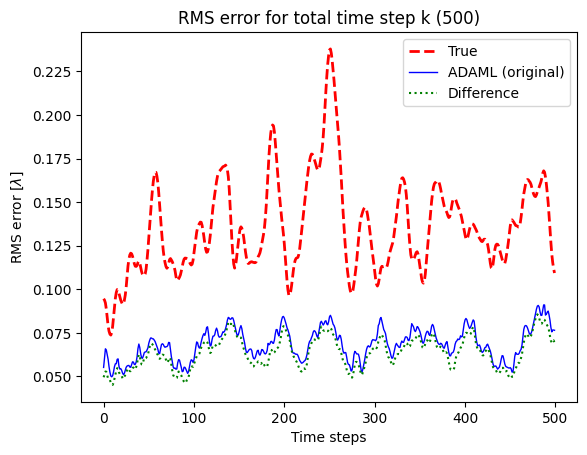

In [295]:
plt.plot(RMS_true_phase/2/pi,'r--',linewidth=2,markersize=8,label='True')
plt.plot(RMS_err_phase_adam/2/pi,'b-',linewidth=1,markersize=6,label=f'ADAML (%s)' %PSF_model)
plt.plot(RMS_phase_diff/2/pi,'g:',linewidth=1.5,markersize=6,label=f'Difference')
plt.legend()
plt.title(f'RMS error for total time step k (%d)' %(iSimStep+1))
plt.xlabel('Time steps')
plt.ylabel('RMS error [$\lambda$]')

plt.show()

In [296]:
# Save the data result based on approx/original PSF 
RMS_err_phase_adam_pd = pd.DataFrame(RMS_err_phase_adam)
RMS_err_phase_adam_pd.to_csv(f'./data_result/est/%s/diff_N/%s/%s/D_r0_%d/%s/RMS_err_phase_adam_n%d.csv' %(algorithm, PSF_model, turbulent_mode, case_num, device, nx), index=False)


T_iter_total_np = np.array(T_iter_total)
T_iter_total_pd = pd.DataFrame(T_iter_total_np)
T_iter_total_pd.to_csv('./data_result/est/%s/diff_N/%s/%s/D_r0_%d/%s/T_iter_total_n%d.csv' %(algorithm, PSF_model, turbulent_mode, case_num, device, nx), index=False)

RMS_true_phase_pd = pd.DataFrame(RMS_true_phase)
RMS_true_phase_pd.to_csv('./data_result/est/%s/diff_N/%s/%s/D_r0_%d/%s/RMS_true_phase_n%d.csv' %(algorithm, PSF_model, turbulent_mode, case_num, device, nx), index=False)

In [ ]:
# # Save the original PSF data
# RMS_err_phase_adam_pd = pd.DataFrame(RMS_err_phase_adam)
# RMS_err_phase_adam_pd.to_csv('RMS_err_phase_adam_original.csv', index=False)

# T_iter_total_np = np.array(T_iter_total)
# T_iter_total_pd = pd.DataFrame(T_iter_total_np)
# T_iter_total_pd.to_csv('T_iter_total_original.csv', index=False)

# RMS_true_phase_pd = pd.DataFrame(RMS_true_phase)
# RMS_true_phase_pd.to_csv('RMS_true_phase.csv', index=False)

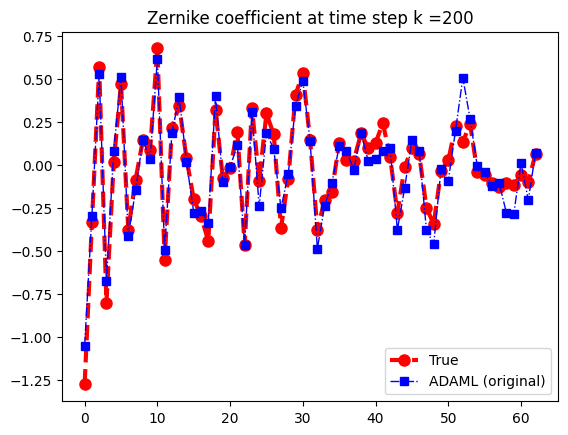

In [ ]:
plt.plot(np.array(ad_acc_valid[iSimStep-1,:]),'ro--',linewidth=3,markersize=8,label='True')
plt.plot(x_adam_total[iSimStep-1,:],'bs-.',linewidth=1,markersize=6,label=f'ADAML (%s)' %PSF_model)
plt.legend()
plt.title(f'Zernike coefficient at time step k =%d' %(iSimStep+1))

plt.show()

# plt.title('Number of Deaths from Lung Diseases in the UK (1974-1979)', fontsize=22)
# plt.yticks(range(y_LL, y_UL, y_interval), [str(y) for y in range(y_LL, y_UL, y_interval)], fontsize=12)    
# plt.xticks(range(0, df.shape[0], 12), df.date.values[::12], horizontalalignment='left', fontsize=12)    
# plt.ylim(y_LL, y_UL)    
# plt.xlim(-2, 80)    
# plt.show()



# D_r0 = f'mag_conv_{case_num}'

# phase = phase * eval(PSF_model);
# ad_acc = ad_acc * eval(D_r0);

In [ ]:
plt.plot(T_iter_total_np_original,'r-',linewidth=3,markersize=8,label=f'Original (%3d)' %np.mean(T_iter_total_np_original))
plt.plot(T_iter_total_np_approx,'b-.',linewidth=1,markersize=6,label=f'Approx (%3d)' %np.mean(T_iter_total_np_approx))
plt.legend()
plt.xlabel('Time steps')
plt.ylabel('Computation time [ms]')
# plt.title(f'Computation time')

plt.show()


NameError: name 'T_iter_total_np_original' is not defined

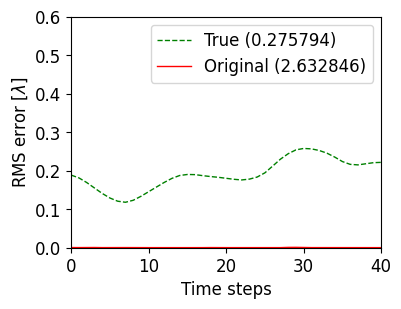

In [ ]:
# print(np.array(ad_acc_valid[iSimStep,:]))
# print(x_adam_np)

plt.plot(RMS_true_phase/2/pi,'g--',linewidth=1,markersize=6,label=f'True (%3f)' %np.mean(RMS_true_phase/2/pi))
plt.plot(RMS_err_phase_adam_original/2/pi,'r-',linewidth=1,markersize=6,label=f'Original (%3f)' %np.mean(RMS_err_phase_adam_original/2/pi))
# plt.plot(RMS_err_phase_adam_approx/2/pi,'b-.',linewidth=1,markersize=6,label=f'Approx (%3f)' %np.mean(RMS_err_phase_adam_approx/2/pi))
plt.legend()
plt.xlabel('Time steps')
plt.ylabel('RMS error [$\lambda$]')
plt.xlim(0, 40)
plt.ylim(0, 0.6)
plt.show()


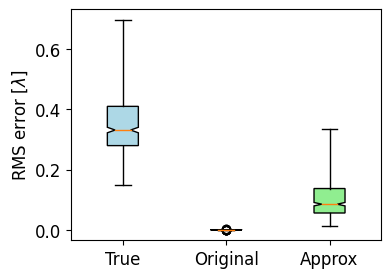

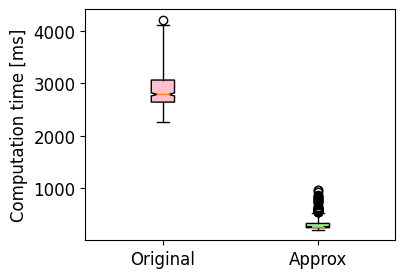

In [ ]:
case_num = 20
# Box plot of RMS error and computation time
plt.style.use('default')
plt.rcParams['figure.figsize'] = (4, 3)
plt.rcParams['font.size'] = 12

####################### RMS error ##########################
# 1. 데이터 로드
RMS_err_phase_adam_original = np.array(pd.read_csv('./data_result/est/D_r0_%d/RMS_err_phase_adam_original.csv' %case_num))
T_iter_total_np_original = np.array(pd.read_csv('./data_result/est/D_r0_%d/T_iter_total_original.csv' %case_num))

RMS_err_phase_adam_approx = np.array(pd.read_csv('./data_result/est/D_r0_%d/RMS_err_phase_adam_approx.csv' %case_num))
T_iter_total_np_approx = np.array(pd.read_csv('./data_result/est/D_r0_%d/T_iter_total_approx.csv' %case_num))

RMS_true_phase = np.array(pd.read_csv('./data_result/est/D_r0_%d/RMS_true_phase.csv' %case_num))

# 2. 데이터 준비
data_a = np.squeeze(RMS_true_phase)/2/pi
data_b = np.squeeze(RMS_err_phase_adam_original)/2/pi
data_c = np.squeeze(RMS_err_phase_adam_approx)/2/pi

# 3. 그래프 그리기
fig1, ax1 = plt.subplots()

bplot1 = ax1.boxplot([data_a, data_b, data_c], notch=True, whis=2.5, patch_artist=True)
# ax1.set_ylim(0, np.max(RMS_true_phase)/2/pi)
# ax1.set_xlabel('Time steps')
ax1.set_ylabel('RMS error [$\lambda$]')
ax1.set_xticks([1, 2, 3], ['True', 'Original', 'Approx'])

colors = ['lightblue', 'pink', 'lightgreen']
for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)

################################################################

####################### RMS error ##########################

# 2. 데이터 준비
data_time_a = np.squeeze(T_iter_total_np_original)
data_time_b = np.squeeze(T_iter_total_np_approx)

# 3. 그래프 그리기
fig2, ax2 = plt.subplots()

bplot2 = ax2.boxplot([data_time_a, data_time_b], notch=True, whis=2.5, patch_artist=True)
# ax2.set_ylim(0, 800)
# ax2.set_xlabel('Time steps')
ax2.set_ylabel('Computation time [ms]')
ax2.set_xticks([1, 2], ['Original', 'Approx'])

colors = ['pink', 'lightgreen'] # 'lightblue', 
for patch, color in zip(bplot2['boxes'], colors):
        patch.set_facecolor(color)

################################################################

In [287]:
print(np.mean(data_a),np.mean(data_b), np.mean(data_c))
print(np.mean(data_time_a),np.mean(data_time_b))


0.3505101339342576 0.000343626386656972 0.10312519244575952
2885.757730957031 321.44681875610354


In [297]:
x = torch.rand(10,10,3, dtype=torch.float64, device=device)

fx_1 = fft.fft2(x[:,:,0])
fx_2 = fft.fftn(x, dim=(0,1))

fx_diff = fx_1 - fx_2[:,:,0]

# I1_defocus = fft.fftshift(fft.fft2(fft.ifftshift(P1_defocus))) * (self.params['dx'] ** 2)
            # fv_im_grad[:,:,k,:] = fft.fftshift(fft.fft2(fft.ifftshift( -2*torch.imag(I1_defocus * torch.conj(I_defocus)[:,:,None]) )))[self.params['range_min']:self.params['range_max'], self.params['range_min']:self.params['range_max'],:]
            
            # for j in range(self.params['nx']):
            #     I1_defocus[:,:,j] = fft.fftshift(fft.fft2(fft.ifftshift(P1_defocus[:,:,j]))) * (self.params['dx'] ** 2)
            #     fv_im_grad[:,:,k,j] = fft.fftshift(fft.fft2(fft.ifftshift( -2*torch.imag(I1_defocus[:,:,j] * torch.conj(I_defocus)) )))[self.params['range_min']:self.params['range_max'], self.params['range_min']:self.params['range_max']]


